In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 100)

file_path_alzheimer = "../../data/raw/ALZHEIMER_Dataset/dataset/alzheimers_disease_data.csv"
data_Alzheimer = pd.read_csv(file_path_alzheimer)

print("Informações do Dataset (Alzheimer):")
print(data_Alzheimer.info())
print("\nAlgumas linhas do Dataset:")
display(data_Alzheimer.head())

data_Alzheimer.drop(columns=["DoctorInCharge", "EducationLevel", "PatientID"], inplace=True, errors="ignore")

Informações do Dataset (Alzheimer):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes    

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,1,1,0,0,142,72,242.366840,56.150897,33.682563,162.189143,21.463532,6.518877,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,0,0,0,0,115,64,231.162595,193.407996,79.028477,294.630909,20.613267,7.118696,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,0,0,0,0,99,116,284.181858,153.322762,69.772292,83.638324,7.356249,5.895077,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,0,0,0,0,118,115,159.582240,65.366637,68.457491,277.577358,13.991127,8.965106,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,0,0,0,0,94,117,237.602184,92.869700,56.874305,291.198780,13.517609,6.045039,0,0,0.014691,0,0,1,1,0,0,XXXConfid


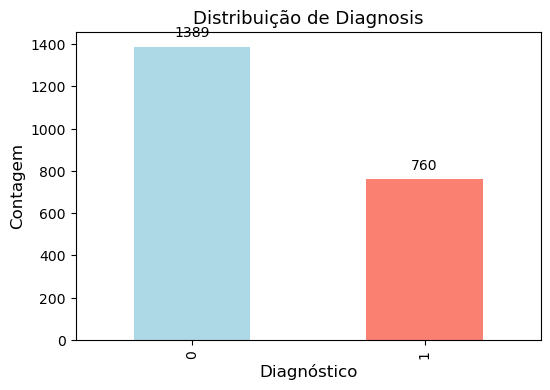

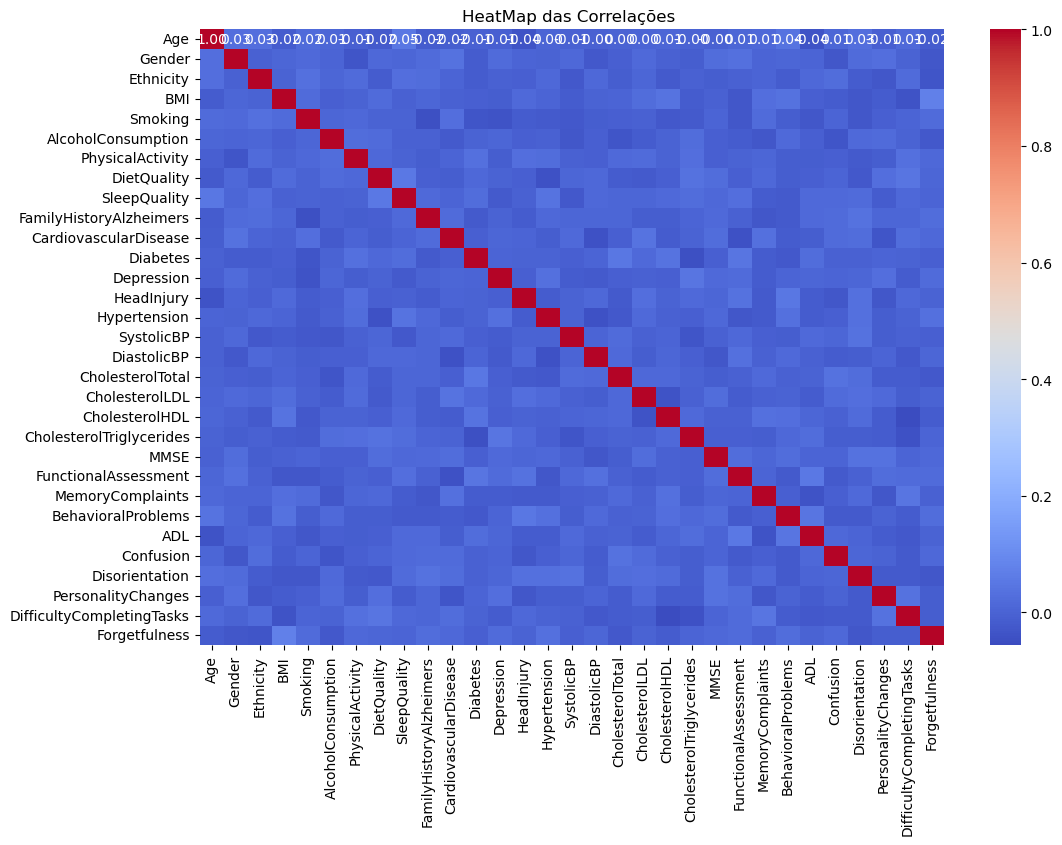

In [2]:
# Análise exploratória

diagnosis_counts = data_Alzheimer["Diagnosis"].value_counts()
plt.figure(figsize=(6,4))
ax = diagnosis_counts.plot(kind="bar", color=["lightblue", "salmon"])
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2.0, p.get_height()),
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                xytext=(0, 5),
                textcoords="offset points")
ax.set_title("Distribuição de Diagnosis", fontsize=13)
ax.set_xlabel("Diagnóstico", fontsize=12)
ax.set_ylabel("Contagem", fontsize=12)
plt.show()

df_alz_numeric = data_Alzheimer.select_dtypes(include=["number"]).copy()
if "Diagnosis" in df_alz_numeric.columns:
    df_alz_numeric.drop(columns=["Diagnosis"], inplace=True, errors="ignore")

plt.figure(figsize=(12, 8))
sns.heatmap(df_alz_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("HeatMap das Correlações ")
plt.show()

In [3]:
# Balanceamento das classes (Over e Under)

type_over_sampling = "resample"  # ou "smote"

if type_over_sampling == "smote":
    X = data_Alzheimer.drop(columns=["Diagnosis"])
    y = data_Alzheimer["Diagnosis"]
    sm = SMOTE(sampling_strategy="minority", random_state=42)
    X_over, y_over = sm.fit_resample(X, y)
    data_over_sampling = pd.concat([
        pd.DataFrame(X_over),
        pd.DataFrame(y_over, columns=["Diagnosis"])
    ], axis=1)
else:
    data_majority = data_Alzheimer[data_Alzheimer["Diagnosis"] == 0].copy()
    data_minority = data_Alzheimer[data_Alzheimer["Diagnosis"] == 1].copy()
    diff = len(data_majority) - len(data_minority)
    if diff > 0:
        data_minority_oversampled = resample(
            data_minority,
            replace=True,
            n_samples=diff,
            random_state=42
        )
        data_minority_oversampled = pd.concat([data_minority, data_minority_oversampled], ignore_index=True)
        data_over_sampling = pd.concat([data_majority, data_minority_oversampled], ignore_index=True)
    else:
        data_over_sampling = data_Alzheimer.copy()

data_majority_orig = data_Alzheimer[data_Alzheimer["Diagnosis"] == 0].copy()
data_minority_orig = data_Alzheimer[data_Alzheimer["Diagnosis"] == 1].copy()
data_minority_generated = data_over_sampling[data_over_sampling["Diagnosis"] == 1].iloc[len(data_minority_orig):].reset_index(drop=True)

if len(data_minority_generated) > 0:
    majority_under_sampling = resample(
        data_majority_orig,
        replace=False,
        n_samples=int(len(data_majority_orig) - len(data_minority_generated) * 0.3),
        random_state=42
    )
    minority_generated_under_sampling = resample(
        data_minority_generated,
        replace=False,
        n_samples=int(len(data_minority_generated) - len(data_minority_generated) * 0.3),
        random_state=42
    )
    minority_under_sampling = pd.concat([data_minority_orig, minority_generated_under_sampling])
    data_under_sampling = pd.concat([minority_under_sampling, majority_under_sampling])
else:
    data_under_sampling = data_Alzheimer.copy()

print("Tamanho (Original):", data_Alzheimer.shape)
print("Tamanho (Over):", data_over_sampling.shape)
print("Tamanho (Under):", data_under_sampling.shape)

Tamanho (Original): (2149, 32)
Tamanho (Over): (2778, 32)
Tamanho (Under): (2400, 32)


In [4]:
# Separar em treino e teste (Original, Over, Under)

X_alz_all = data_Alzheimer.drop(columns=["Diagnosis"])
y_alz = data_Alzheimer["Diagnosis"]

X_over_all = data_over_sampling.drop(columns=["Diagnosis"])
y_over = data_over_sampling["Diagnosis"]

X_under_all = data_under_sampling.drop(columns=["Diagnosis"])
y_under = data_under_sampling["Diagnosis"]

X_train_alz, X_test_alz, y_train_alz, y_test_alz = train_test_split(
    X_alz_all, y_alz, test_size=0.2, random_state=42, shuffle=True
)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    X_over_all, y_over, test_size=0.2, random_state=42, shuffle=True
)
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_under_all, y_under, test_size=0.2, random_state=42, shuffle=True
)

In [5]:
# Função de avaliação dos modelos

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Modelo", do_prob=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== AVALIAÇÃO: {model_name.upper()} ===")
    print(classification_report(y_test, y_pred, digits=4))
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy de Teste: {acc:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusão:")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap="Blues", colorbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()
    if do_prob and hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc_val = auc(fpr, tpr)
        print(f"AUC: {roc_auc_val:.4f}")
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc_val:.3f})")
        plt.plot([0,1],[0,1],"r--")
        plt.xlim([0,1])
        plt.ylim([0,1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend(loc="lower right")
        plt.show()
    return acc, model


In [6]:
# GridSearch para a procura dos hiperparâmetros

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_gridsearch_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, model_name="Modelo"):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="accuracy",
        cv=skf,
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)
    print(f"\nMelhores Parâmetros ({model_name}): {gs.best_params_}")
    best_model = gs.best_estimator_
    acc, trained_model = evaluate_model(best_model, X_train, y_train, X_test, y_test, model_name=model_name)
    return acc, trained_model, gs.best_params_

param_grid_knn = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"]
}
param_grid_logistic = {
    "C": [0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"]
}
param_grid_svm = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"]
}
param_grid_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 2],
    "class_weight": ["balanced", "balanced_subsample"]
}


##### MODELOS NO DATASET: ORIGINAL #####

--- GridSearch para: KNN ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (KNN): {'n_neighbors': 7, 'weights': 'uniform'}

=== AVALIAÇÃO: KNN ===
              precision    recall  f1-score   support

           0     0.6335    0.7365    0.6811       277
           1     0.3241    0.2288    0.2682       153

    accuracy                         0.5558       430
   macro avg     0.4788    0.4826    0.4747       430
weighted avg     0.5234    0.5558    0.5342       430

Acurácia de Teste: 0.5558
Matriz de Confusão:
[[204  73]
 [118  35]]


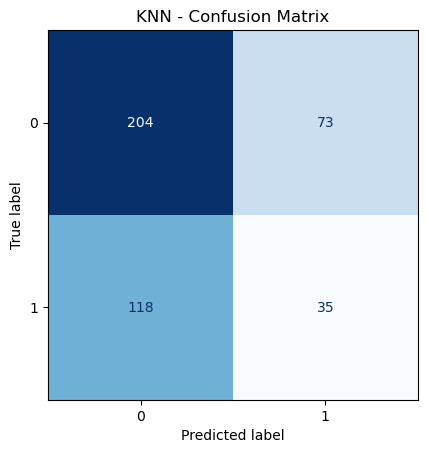

AUC: 0.5033


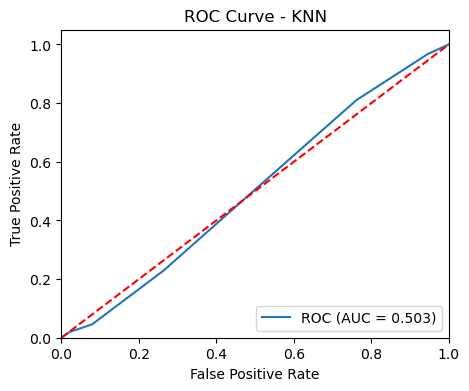

--- GridSearch para: LogisticRegression ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (LogisticRegression): {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

=== AVALIAÇÃO: LOGISTICREGRESSION ===
              precision    recall  f1-score   support

           0     0.8527    0.8989    0.8752       277
           1     0.7971    0.7190    0.7560       153

    accuracy                         0.8349       430
   macro avg     0.8249    0.8089    0.8156       430
weighted avg     0.8329    0.8349    0.8328       430

Acurácia de Teste: 0.8349
Matriz de Confusão:
[[249  28]
 [ 43 110]]


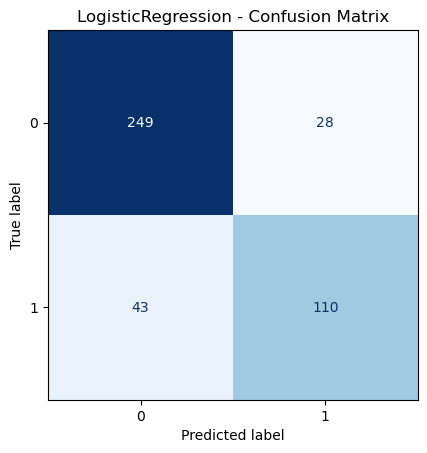

AUC: 0.8893


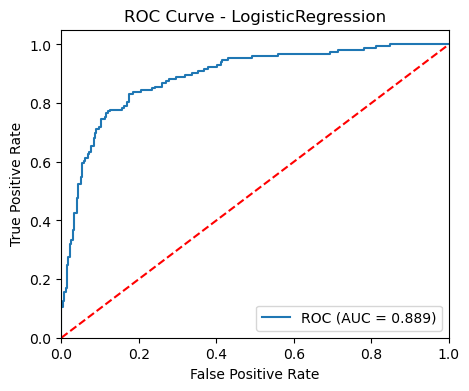

--- GridSearch para: SVM ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (SVM): {'C': 0.1, 'kernel': 'linear'}

=== AVALIAÇÃO: SVM ===
              precision    recall  f1-score   support

           0     0.8526    0.8773    0.8648       277
           1     0.7655    0.7255    0.7450       153

    accuracy                         0.8233       430
   macro avg     0.8091    0.8014    0.8049       430
weighted avg     0.8216    0.8233    0.8221       430

Acurácia de Teste: 0.8233
Matriz de Confusão:
[[243  34]
 [ 42 111]]


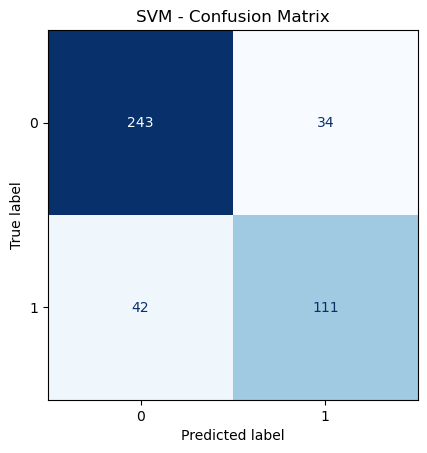

AUC: 0.8905


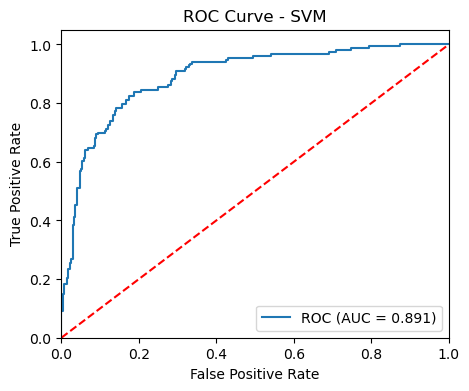

--- GridSearch para: DecisionTree ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Melhores Parâmetros (DecisionTree): {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}

=== AVALIAÇÃO: DECISIONTREE ===
              precision    recall  f1-score   support

           0     0.9078    0.9603    0.9333       277
           1     0.9197    0.8235    0.8690       153

    accuracy                         0.9116       430
   macro avg     0.9138    0.8919    0.9011       430
weighted avg     0.9121    0.9116    0.9104       430

Acurácia de Teste: 0.9116
Matriz de Confusão:
[[266  11]
 [ 27 126]]


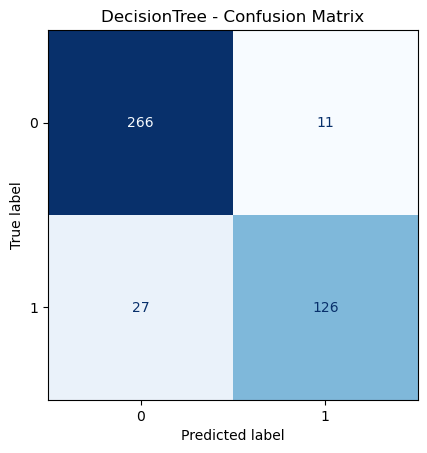

AUC: 0.9048


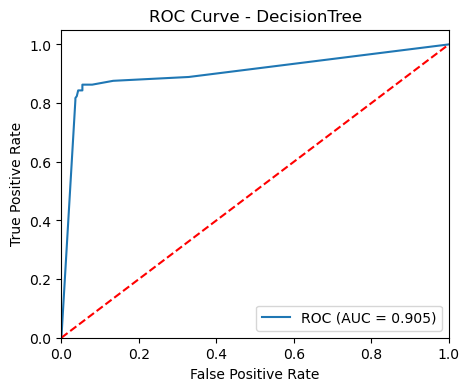

--- GridSearch para: RandomForest ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Melhores Parâmetros (RandomForest): {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}

=== AVALIAÇÃO: RANDOMFOREST ===
              precision    recall  f1-score   support

           0     0.9283    0.9819    0.9544       277
           1     0.9635    0.8627    0.9103       153

    accuracy                         0.9395       430
   macro avg     0.9459    0.9223    0.9324       430
weighted avg     0.9408    0.9395    0.9387       430

Acurácia de Teste: 0.9395
Matriz de Confusão:
[[272   5]
 [ 21 132]]


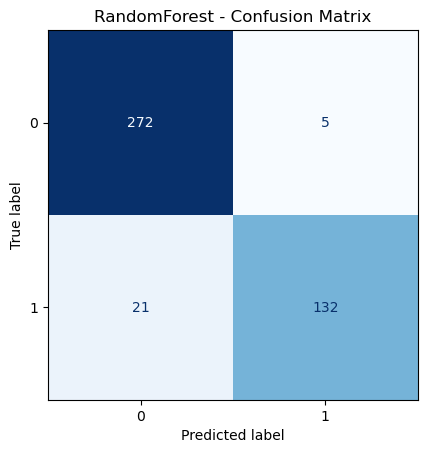

AUC: 0.9537


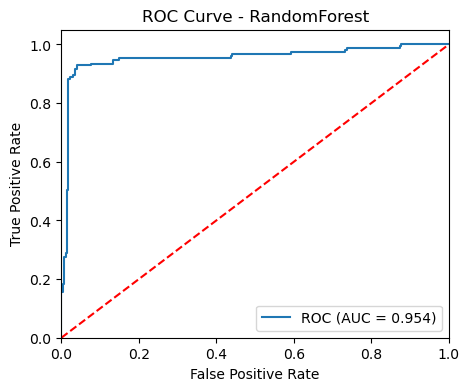


##### MODELOS NO DATASET: OVER #####

--- GridSearch para: KNN ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (KNN): {'n_neighbors': 3, 'weights': 'distance'}

=== AVALIAÇÃO: KNN ===
              precision    recall  f1-score   support

           0     0.7732    0.5282    0.6276       284
           1     0.6298    0.8382    0.7192       272

    accuracy                         0.6799       556
   macro avg     0.7015    0.6832    0.6734       556
weighted avg     0.7031    0.6799    0.6724       556

Acurácia de Teste: 0.6799
Matriz de Confusão:
[[150 134]
 [ 44 228]]


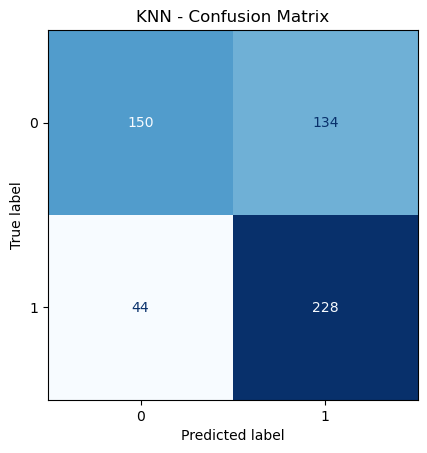

AUC: 0.7824


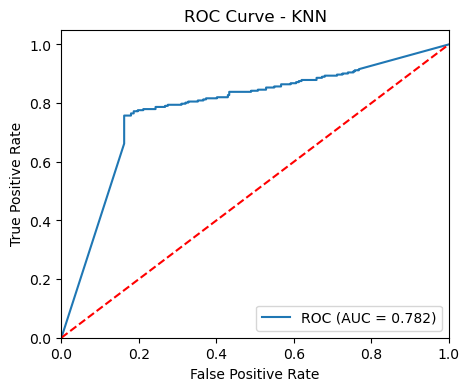

--- GridSearch para: LogisticRegression ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (LogisticRegression): {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

=== AVALIAÇÃO: LOGISTICREGRESSION ===
              precision    recall  f1-score   support

           0     0.8273    0.8099    0.8185       284
           1     0.8058    0.8235    0.8145       272

    accuracy                         0.8165       556
   macro avg     0.8165    0.8167    0.8165       556
weighted avg     0.8168    0.8165    0.8166       556

Acurácia de Teste: 0.8165
Matriz de Confusão:
[[230  54]
 [ 48 224]]


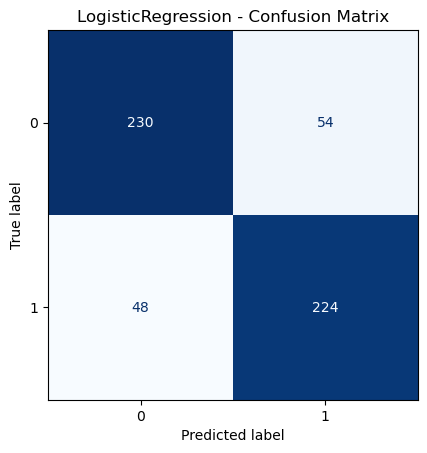

AUC: 0.8996


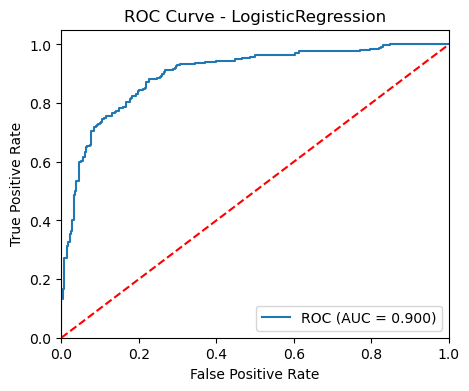

--- GridSearch para: SVM ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (SVM): {'C': 0.1, 'kernel': 'linear'}

=== AVALIAÇÃO: SVM ===
              precision    recall  f1-score   support

           0     0.8273    0.8099    0.8185       284
           1     0.8058    0.8235    0.8145       272

    accuracy                         0.8165       556
   macro avg     0.8165    0.8167    0.8165       556
weighted avg     0.8168    0.8165    0.8166       556

Acurácia de Teste: 0.8165
Matriz de Confusão:
[[230  54]
 [ 48 224]]


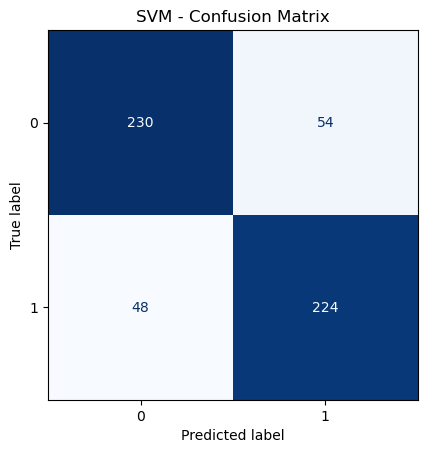

AUC: 0.8921


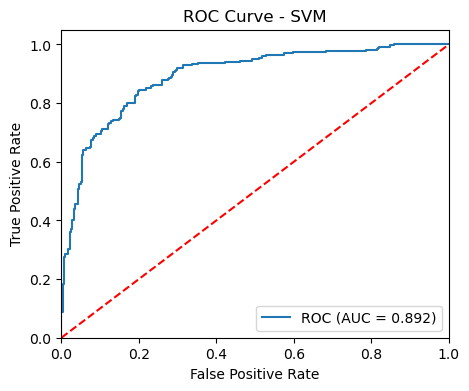

--- GridSearch para: DecisionTree ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Melhores Parâmetros (DecisionTree): {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}

=== AVALIAÇÃO: DECISIONTREE ===
              precision    recall  f1-score   support

           0     0.9017    0.9366    0.9188       284
           1     0.9310    0.8934    0.9118       272

    accuracy                         0.9155       556
   macro avg     0.9164    0.9150    0.9153       556
weighted avg     0.9160    0.9155    0.9154       556

Acurácia de Teste: 0.9155
Matriz de Confusão:
[[266  18]
 [ 29 243]]


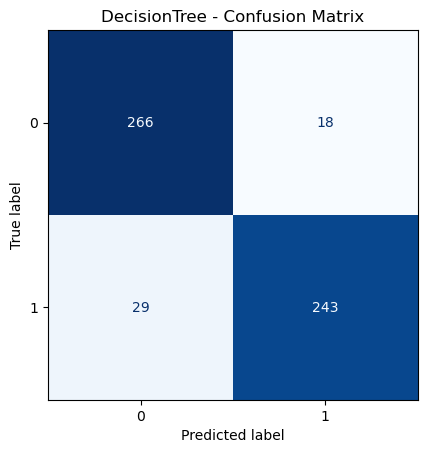

AUC: 0.9294


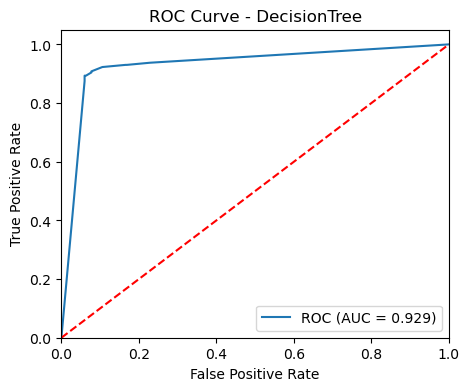

--- GridSearch para: RandomForest ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Melhores Parâmetros (RandomForest): {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}

=== AVALIAÇÃO: RANDOMFOREST ===
              precision    recall  f1-score   support

           0     0.9488    0.9789    0.9636       284
           1     0.9772    0.9449    0.9607       272

    accuracy                         0.9622       556
   macro avg     0.9630    0.9619    0.9622       556
weighted avg     0.9627    0.9622    0.9622       556

Acurácia de Teste: 0.9622
Matriz de Confusão:
[[278   6]
 [ 15 257]]


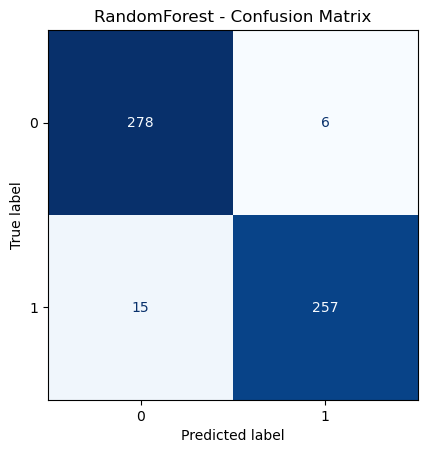

AUC: 0.9873


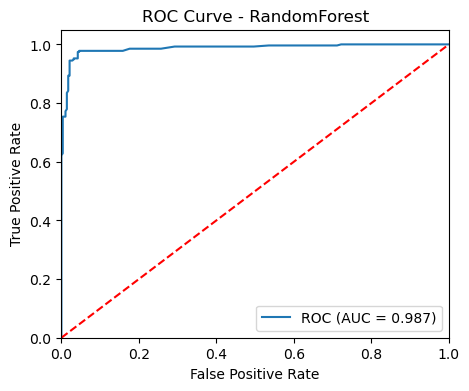


##### MODELOS NO DATASET: UNDER #####

--- GridSearch para: KNN ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (KNN): {'n_neighbors': 3, 'weights': 'distance'}

=== AVALIAÇÃO: KNN ===
              precision    recall  f1-score   support

           0     0.7056    0.5991    0.6480       232
           1     0.6714    0.7661    0.7156       248

    accuracy                         0.6854       480
   macro avg     0.6885    0.6826    0.6818       480
weighted avg     0.6879    0.6854    0.6830       480

Acurácia de Teste: 0.6854
Matriz de Confusão:
[[139  93]
 [ 58 190]]


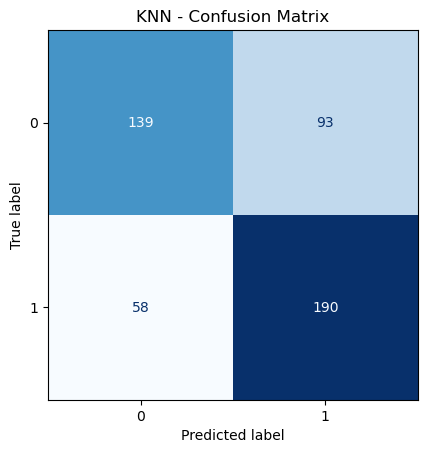

AUC: 0.7457


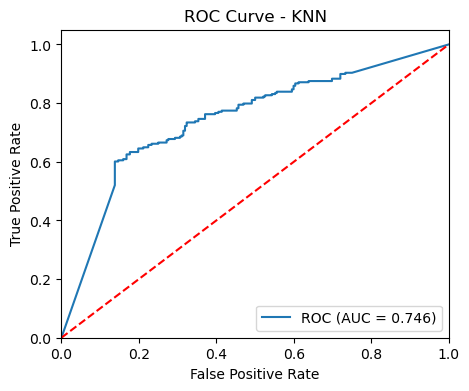

--- GridSearch para: LogisticRegression ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (LogisticRegression): {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

=== AVALIAÇÃO: LOGISTICREGRESSION ===
              precision    recall  f1-score   support

           0     0.8333    0.8405    0.8369       232
           1     0.8496    0.8427    0.8462       248

    accuracy                         0.8417       480
   macro avg     0.8415    0.8416    0.8415       480
weighted avg     0.8417    0.8417    0.8417       480

Acurácia de Teste: 0.8417
Matriz de Confusão:
[[195  37]
 [ 39 209]]


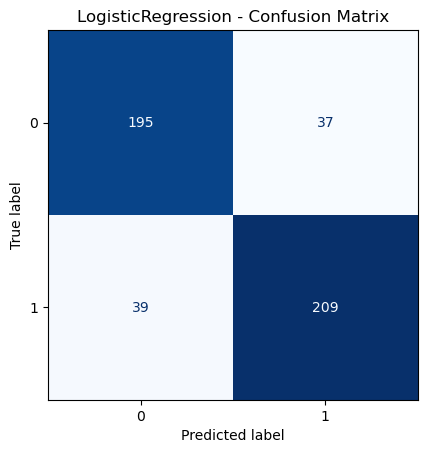

AUC: 0.9193


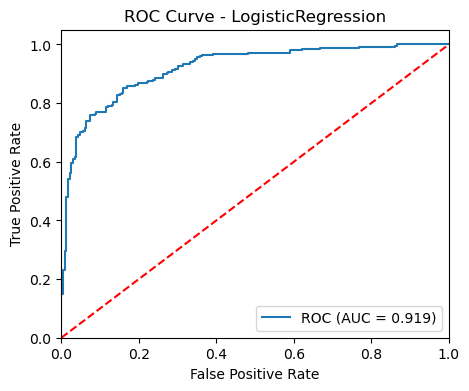

--- GridSearch para: SVM ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (SVM): {'C': 0.1, 'kernel': 'linear'}

=== AVALIAÇÃO: SVM ===
              precision    recall  f1-score   support

           0     0.8263    0.8405    0.8333       232
           1     0.8484    0.8347    0.8415       248

    accuracy                         0.8375       480
   macro avg     0.8373    0.8376    0.8374       480
weighted avg     0.8377    0.8375    0.8375       480

Acurácia de Teste: 0.8375
Matriz de Confusão:
[[195  37]
 [ 41 207]]


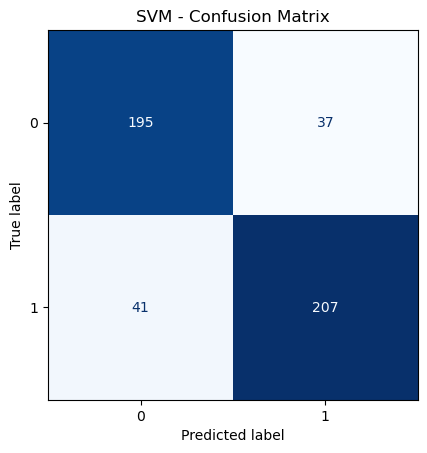

AUC: 0.9196


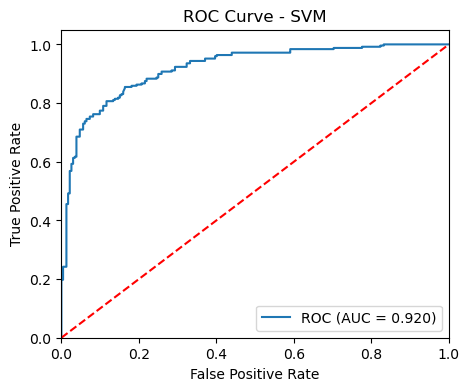

--- GridSearch para: DecisionTree ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Melhores Parâmetros (DecisionTree): {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}

=== AVALIAÇÃO: DECISIONTREE ===
              precision    recall  f1-score   support

           0     0.9478    0.9397    0.9437       232
           1     0.9440    0.9516    0.9478       248

    accuracy                         0.9458       480
   macro avg     0.9459    0.9456    0.9458       480
weighted avg     0.9458    0.9458    0.9458       480

Acurácia de Teste: 0.9458
Matriz de Confusão:
[[218  14]
 [ 12 236]]


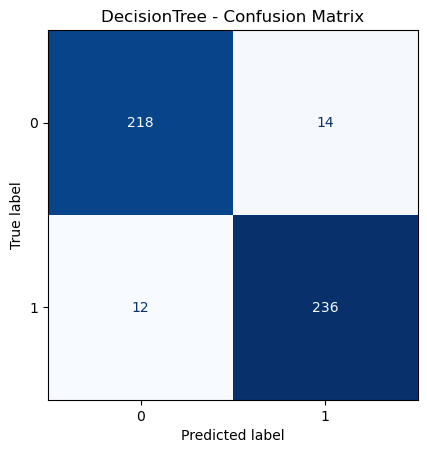

AUC: 0.9498


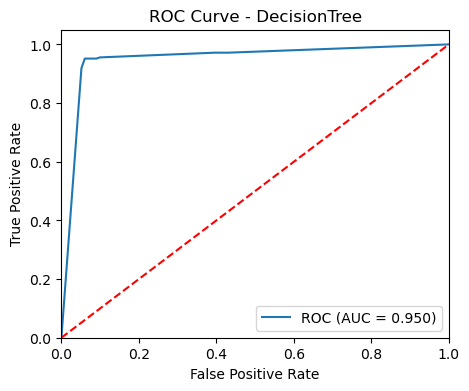

--- GridSearch para: RandomForest ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Melhores Parâmetros (RandomForest): {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}

=== AVALIAÇÃO: RANDOMFOREST ===
              precision    recall  f1-score   support

           0     0.9658    0.9741    0.9700       232
           1     0.9756    0.9677    0.9717       248

    accuracy                         0.9708       480
   macro avg     0.9707    0.9709    0.9708       480
weighted avg     0.9709    0.9708    0.9708       480

Acurácia de Teste: 0.9708
Matriz de Confusão:
[[226   6]
 [  8 240]]


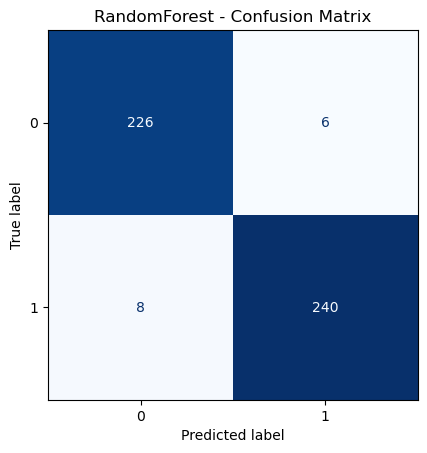

AUC: 0.9800


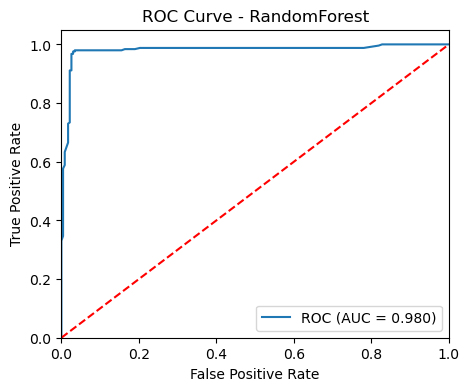

In [7]:
# Execução do GridSearch para cada modelo e conjunto

models_and_grids = [
    ("KNN", KNeighborsClassifier(), param_grid_knn),
    ("LogisticRegression", LogisticRegression(random_state=42), param_grid_logistic),
    ("SVM", SVC(probability=True, random_state=42), param_grid_svm),
    ("DecisionTree", DecisionTreeClassifier(random_state=42), param_grid_dt),
    ("RandomForest", RandomForestClassifier(random_state=42), param_grid_rf),
]

results_all = {
    "Original": {},
    "Over": {},
    "Under": {}
}

def run_all_models_on_dataset(models_and_grids, X_train, y_train, X_test, y_test, dataset_name="Original"):
    local_results = {}
    print(f"\n##### MODELOS NO DATASET: {dataset_name} #####\n")
    for (model_name, model, param_grid) in models_and_grids:
        print(f"--- GridSearch para: {model_name} ---")
        best_acc, best_model, best_params = run_gridsearch_and_evaluate(
            model, param_grid, X_train, y_train, X_test, y_test, model_name=model_name
        )
        local_results[model_name] = {
            "best_accuracy": best_acc,
            "best_params": best_params
        }
    return local_results

results_all["Original"] = run_all_models_on_dataset(
    models_and_grids,
    X_train_alz, y_train_alz,
    X_test_alz, y_test_alz,
    dataset_name="ORIGINAL"
)

results_all["Over"] = run_all_models_on_dataset(
    models_and_grids,
    X_train_over, y_train_over,
    X_test_over, y_test_over,
    dataset_name="OVER"
)

results_all["Under"] = run_all_models_on_dataset(
    models_and_grids,
    X_train_under, y_train_under,
    X_test_under, y_test_under,
    dataset_name="UNDER"
)


In [8]:
print("\n\n============= RESULTADOS FINAIS =============\n")
for ds in ["Original", "Over", "Under"]:
    print(f"\n*** Dataset: {ds} ***")
    for model_name, info in results_all[ds].items():
        acc = info["best_accuracy"]
        params = info["best_params"]
        print(f"{model_name:<18} -> Accuracy: {acc:.4f} | BestParams: {params}")



============= RESULTADOS FINAIS =============


*** Dataset: Original ***
KNN                -> Accuracy: 0.5558 | BestParams: {'n_neighbors': 7, 'weights': 'uniform'}
LogisticRegression -> Accuracy: 0.8349 | BestParams: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
SVM                -> Accuracy: 0.8233 | BestParams: {'C': 0.1, 'kernel': 'linear'}
DecisionTree       -> Accuracy: 0.9116 | BestParams: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}
RandomForest       -> Accuracy: 0.9395 | BestParams: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}

*** Dataset: Over ***
KNN                -> Accuracy: 0.6799 | BestParams: {'n_neighbors': 3, 'weights': 'distance'}
LogisticRegression -> Accuracy: 0.8165 | BestParams: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
SVM                -> Accuracy: 0.8165 | BestParams: {'C': 0.1, 'kernel': 'linear'}
DecisionTree       -> Accuracy: 0.9155 | BestParams: {'criterion': '

In [ ]:
#--- Dataset: Original ---
#KNN                -> Accuracy: 0.5558 | BestParams: {'n_neighbors': 7, 'weights': 'uniform'}
#LogisticRegression -> Accuracy: 0.8349 | BestParams: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
#SVM                -> Accuracy: 0.8233 | BestParams: {'C': 0.1, 'kernel': 'linear'}
#DecisionTree       -> Accuracy: 0.9116 | BestParams: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}
#RandomForest       -> Accuracy: 0.9395 | BestParams: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}
#
#--- Dataset: Over ---
#KNN                -> Accuracy: 0.6799 | BestParams: {'n_neighbors': 3, 'weights': 'distance'}
#LogisticRegression -> Accuracy: 0.8165 | BestParams: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
#SVM                -> Accuracy: 0.8165 | BestParams: {'C': 0.1, 'kernel': 'linear'}
#DecisionTree       -> Accuracy: 0.9155 | BestParams: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}
#RandomForest       -> Accuracy: 0.9622 | BestParams: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
#
#--- Dataset: Under ---
#KNN                -> Accuracy: 0.6854 | BestParams: {'n_neighbors': 3, 'weights': 'distance'}
#LogisticRegression -> Accuracy: 0.8417 | BestParams: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
#SVM                -> Accuracy: 0.8375 | BestParams: {'C': 0.1, 'kernel': 'linear'}
#DecisionTree       -> Accuracy: 0.9458 | BestParams: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
#RandomForest       -> Accuracy: 0.9708 | BestParams: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}